# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [1]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math

from observation_model import get_nnet

from multiprocessing import Pool, Process
from multiprocessing.pool import ThreadPool
import threading

import importlib
import fst_graph
from fst_graph import *
importlib.reload(fst_graph)

# %run language_model.ipynb

<module 'fst_graph' from '/afs/inf.ed.ac.uk/user/s26/s2653879/Documents/ASR/asr_assignment/fst_graph.py'>

In [2]:
def add_to_file(file: str, txt: str):
    f = open(file, 'a')
    f.write(txt)
    f.close()

In [3]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is not really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name, nnet, loaded_first_rec):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel(nnet, loaded_first_rec)
        self.f = f
        
        self.cache_prob = {}
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
        
    def get_om_prob(self, phone_state: str, t: int):
        key = f'{phone_state} {t}'
        if key in self.cache_prob:
            return self.cache_prob[key]
        
        value = self.om.log_observation_probability(phone_state, t)
        self.cache_prob[key] = value
        return value
    
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []
        self.B = [] # B[t][i]
        self.W = []
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append(['']*self.f.num_states())
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        start_state = self.f.start()
        N = len(lex)
        for arc in self.f.arcs(start_state):
            s = arc.nextstate
            self.V[0][s] = -math.log(1/N)

        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """

        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            olbl = arc.olabel
                            olbl = self.f.output_symbols().find(olbl)
                            self.W[t][j] = self.W[t][i] + " " + olbl
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.get_om_prob(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
#                         print(tp, ep, self.V[t-1][i])
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            olbl = arc.olabel
                            olbl = self.f.output_symbols().find(olbl)
                            self.W[t][j] = olbl
    
    def finalise_decoding(self):
        
        # TODO - exercise
        states = list(range(self.f.num_states()))
        for i in states:
            prob_final = float(self.f.final(i)) # probablity of being the end state (0 for non finals, and upwards of 1 if one final state, or split between all final states)
            if (self.V[-1][i] < self.NLL_ZERO):
                if (prob_final == math.inf): # not a final state
                    self.V[-1][i] = self.NLL_ZERO
                else: # is a final state
                    self.V[-1][i] += prob_final # includes the weighting of ending at each of the final states in the path towards them in the last step
        
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.traverse_epsilon_arcs(t)
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        
        self.finalise_decoding()
    
    def backtrace(self):
        T = self.om.observation_length()
        current = -1
        for i in range(self.f.num_states()):
            if (float(self.f.final(i)) != math.inf): # if i is final
                if (self.B[T][i] != -1):
                    if (current == -1):
                        current = i
                    elif (self.V[-1][current] > self.V[-1][i]):
                        current = i
        if (current == -1):
            raise Exception('No valid path')
        seq = [current]
        currentStr = ''
        strSeq = ''
        
        for t in range(T,-1, -1):
            tmp_str = self.W[t][current].split(" ")
            for tmpStr in tmp_str:
                if not(tmpStr in ['', '<eps>']):
                    currentStr = tmpStr
                    strSeq = f'{currentStr} {strSeq}'


                current = self.B[t][current]
                seq.insert(0, current)
        
        
        strSeq = strSeq.strip()
        best_state_sequence = (seq, strSeq)
        
        return best_state_sequence

In [4]:
class ResultsPrinter:
    def __init__(self, useFile=True):
        self.count = 0
        self.useFile = useFile
        
        if self.useFile:
            with open("results_printer_counter.txt", "w") as f:
                f.write("0")
                
    def clear(self):
        self.count = 0
        self.set_counter(0)
        
    def get_counter(self) -> int:
        if not self.useFile:
            return self.count
        
        counter = self.count
        try:
            with open("restult_printer_counter.txt", "r") as f:
                counter = int(f.read())
        except:
            pass

        return counter
    
    def set_counter(self, new_val: int):
        if not self.useFile:
            self.count = new_val
            return
        
        with open("restult_printer_counter.txt", "w") as f:
            f.write(str(new_val))
    
    def increment_counter(self):
        if not self.useFile:
            self.count += 1
            return
        
        c = self.get_counter()
        self.set_counter(c + 1)
    
    def print(self, txt):
        count = self.get_counter()
        print(f"{count}:\n{txt}")
        
        self.increment_counter()
    
resP = ResultsPrinter()

In [5]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

# def proc_run(inputArgs):
#     files, f, start, isPrint = inputArgs

class bool_atr:
    def __init__(self, data):
        self.data = data
    def get_data(self):
        return self.data
    def set_data(self, new_data):
        self.data = new_data

def proc_run(files, f, start=0, isPrint=False):
    res_results = ""
    res_wer = ""
    counter = start
    
    nnet = get_nnet()
    loaded_first_rec = bool_atr(False)
    for wav_file in files:
        decoder = MyViterbiDecoder(f, wav_file, nnet, loaded_first_rec)
        
        decoder.decode()
#         print(decoder.V)
#         input()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                                   # to return the words along the best path


        transcription = read_transcription(wav_file)
        text = (f"\n\n[{wav_file}]\n\n{state_path}\n\n[{words}]\n[{transcription}]")
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        res = f'{error_counts} {word_count}\n'     # you'll need to accumulate these to produce an overall Word Error Rate
        
        txt = f'{counter}\n{words}\n{transcription}\n{res}'
        if isPrint:
            print(txt)
        else:
            resP.print(txt)

        add_to_file('results.txt', f'{text}\n{res}')
        res_results += f"{text}\n{res}"
        add_to_file('wer_data.txt', res)
        res_wer += res
        
        counter += 1

    del(nnet)
    return res_results, res_wer

def run(is_copy=True):
    f = create_wfst()
    resP.clear()
    
    files = list(glob.glob('/group/teaching/asr/labs/recordings/*.wav'))
    
    if (is_copy):
        # copy to prev
        with open('results_prev.txt', 'w') as file:
            with open('results.txt', 'r') as file2:
                file.write(file2.read())
        with open('wer_data_prev.txt', 'w') as file:
            with open('wer_data.txt', 'r') as file2:
                file.write(file2.read())
    
    # clear results file
    with open('results.txt', 'w') as file:
        pass
    # clear results file
    with open('wer_data.txt', 'w') as file:
        pass

    # 10:15
    # 37:42
    start = 10
    end = 15

    start = 37
    end = 42
    
#     start = 11
#     end = 12

#     start = 0
#     end = len(files)

#     proc_run(files[start:end], f, start, True)

#     minis = [
#         files[11],
#         files[132],
#         files[6],
#         files[318],
#         files[10]
#     ]
#     mids = [
#         files[9],
#         files[109],
#         files[153],
#         files[182],
#         files[206]
#     ]
#     proc_run(minis, f, start, True)

    # multiprocessing
#     proc_run(files[10:20], f, 0, True)
    thread_size = 20
    proc_run_args = []
    for i in range(0, len(files)-thread_size, thread_size):
        start = i
        end = i+thread_size
        end = end if end <= len(files) else len(files)
        proc_run_args.append((files[start:end], f, start, False))
    
    with Pool() as p:
        p.starmap(proc_run, proc_run_args)
    
    #multithreading
#     with ThreadPool() as ts:
#         ts.starmap(proc_run, proc_run_args)

In [6]:
%%timeit -r 1 -n 1
# run(True)
if __name__ == "__main__":
    run(False)

0:
120
a peck pickled peter picked
peck pickled peter
(0, 0, 2) 3

1:
60
a peck piper peter of pickled peck picked
peck piper peter pickled picked
(0, 0, 3) 5

2:
140
a of of of pickled peck picked pickled peck peppers picked
peter piper picked a peck of pickled peppers
(5, 0, 3) 8

3:
220
a peck of peck of pickled peter peter of piper picked picked
where's the peck of pickled peppers peter piper picked
(3, 0, 3) 9

4:
40
a peck peter picked where's the pickled peppers peter picked
piper peter picked where's the pickled peppers peter
(1, 0, 2) 8

5:
180
a peter peter picked a peck of pickled peppers peck
peter piper picked a peck of pickled peppers
(1, 0, 2) 8

6:
160
a a of piper of picked of peck of pickled piper peppers picked
peter piper picked a peck of pickled peppers
(2, 0, 5) 8

7:
80
a peck peter picked peck of picked pickled piper picked
a peter picked peck of picked pickled piper
(0, 0, 2) 8

8:
100
a the picked of piper picked of pickled a peter piper picked
the picked of p


68:
146
a peppers peter piper picked
where's peter piper
(1, 0, 2) 3

69:
128
a pickled pickled picked
piper pickled pickled
(1, 0, 1) 3

70:
226
a peppers peppers of peck peter picked
where's the piper of peck peter
(3, 0, 1) 6

71:
46
a the pickled pickled peck peppers of of picked
peter picked peppers of the pickled peck of peppers of piper
(2, 4, 2) 11

72:
166
a the a piper picked a peck of pickled peppers picked
peter piper picked a peck of pickled peppers
(1, 0, 3) 8

73:
186
a peter pickled peck of peppers picked
peter pickled a peck of peppers
(0, 1, 2) 6

74:
4
pickled where's pickled pickled peppers picked picked
where's the peck of pickled peppers picked
(1, 2, 2) 7

75:
205
a peter piper peck peppers picked peter peppers picked
peter piper peck peppers picked peter peppers
(0, 0, 2) 7

76:
227
a the a picked peck of picked peppers picked
peter picked a peck of pickled peppers
(3, 0, 2) 7

76:
147
a where's pickled peck peppers picked
where's pickled peppers
(0, 0, 3) 3

7


140:
13
a piper picked
piper
(0, 0, 2) 1

141:
211
a piper of peppers where's of peter picked peck picked
piper pickled peppers where's a peter picked a peck
(2, 1, 2) 9

142:
91
a where's peck of picked
where's the peck of
(0, 1, 2) 4

143:
136
a where's the peck of pickled picked peppers picked
where's the peck of pickled peppers
(0, 0, 3) 6

144:
153
a where's of peck of peppers peter piper picked picked
where's the peck of peppers peter piper picked
(1, 0, 2) 8

145:
69
a pickled pickled a pickled peter of peppers peppers piper picked
picked pickled a pickled peter of peppers peppers piper
(1, 0, 2) 9

146:
110
a peter of peppers picked of piper of the peck picked
peter peppers picked a piper of the peck
(1, 0, 3) 8

147:
14
a peter picked
peter
(0, 0, 2) 1

148:
172
a peck the peck pickled piper peter piper picked peck
where's the peck of pickled peppers peter piper picked
(2, 1, 2) 9

149:
52
a peter piper picked peck pickled peppers picked
peter piper picked a peck of pickled p


37:
37
a picked piper picked peck of pickled peppers picked
peter piper picked a peck of pickled peppers
(1, 1, 2) 8

38:
116
a of picked of peck pickled of peppers picked picked picked
piper picked the peck of pickled peppers peter picked
(3, 1, 3) 9

39:
261
a where's of picked of picked picked
where's the peck peter picked
(3, 0, 2) 5

0:
99
a the peck pickled peppers picked pickled peter of piper a where's picked
the peck pickled peppers picked pickled peter of piper a where's
(0, 0, 2) 11

41:
214
a peck pickled pickled peppers picked piper a where's pickled peppers picked
a peck of pickled peppers peter piper picked where's the peck of pickled peppers
(3, 3, 1) 14

42:
177
a where's the peck of pickled a peppers peter piper picked picked
where's the peck of pickled peppers peter piper picked
(0, 0, 3) 9

43:
243
a picked of peck of peppers piper pickled picked
where's the peck of peppers piper pickled
(2, 0, 2) 7

44:
75
a piper of piper of peck pickled picked pickled of peter p


110:
253
a of peppers a of peck pickled peter piper peck picked
of peppers where's a peck the pickled peter piper picked
(0, 2, 3) 10

111:
293
a peck piper picked peck peck peck
peter piper picked a peck
(2, 0, 2) 5

112:
274
a peter piper picked peppers picked
peter piper picked peppers
(0, 0, 2) 4

113:
310
a the picked pickled picked peck peppers picked peck of a peppers peppers picked the peck peck picked
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(7, 3, 4) 17

114:
198
a peter of a pickled peck of pickled peppers picked peck peck of pickled peppers picked picked picked picked
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(5, 1, 3) 17

115:
275
a pickled peppers picked picked
pickled peppers picked
(0, 0, 2) 3

116:
254
a picked piper picked peck of pickled peppers a the peck of pickled peppers peter piper picked
peter piper picked a peck of pickled peppers where's the p

In [8]:
file = open('wer_data.txt', 'r')
wer_counts = file.read()
file.close()
S, D, I, N = 0, 0, 0, 0
wer_counts = wer_counts.strip().split("\n")
IndexCount = len(wer_counts)
for wer_elem in wer_counts:
    wer_elem = wer_elem.replace("(", "").replace(")", "").replace(",", "").split(" ")
    S += int(wer_elem[0])
    D += int(wer_elem[1])
    I += int(wer_elem[2])
    N += int(wer_elem[3])

WER = (S + D + I) / N
print(IndexCount, WER, S, D, I, N)

320 0.5456475583864119 423 159 703 2355


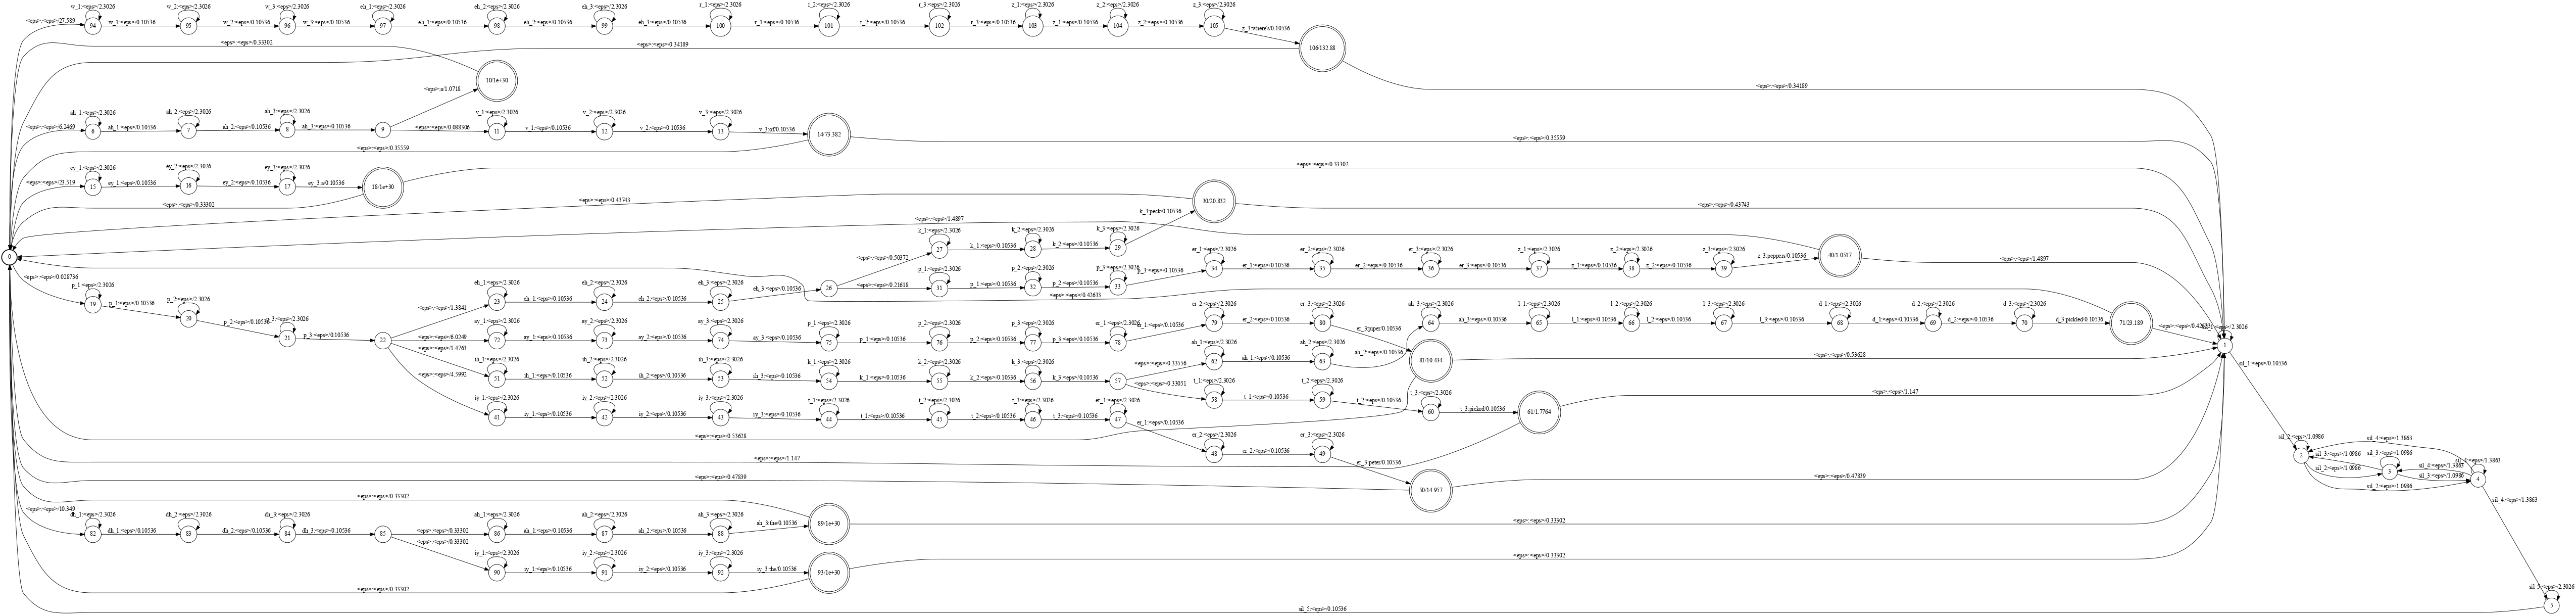

In [8]:
f = create_wfst()
draw_f(f)